
# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 3

## Import libraries and setup matplotlib

In [3]:
import matplotlib.pylab as plt

# # Download tokenizer if not present
# import nltk
# nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import cleaned_text_to_sequence, intersperse, _clean_text, sequence_to_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
from hifigandenoiser import Denoiser
%matplotlib inline



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
%ls checkpoints/VCTK

checkpoint_0.ckpt      checkpoint_17000.ckpt  checkpoint_25000.ckpt
checkpoint_10000.ckpt  checkpoint_17500.ckpt  checkpoint_2500.ckpt
checkpoint_1000.ckpt   checkpoint_18000.ckpt  checkpoint_3000.ckpt
checkpoint_10500.ckpt  checkpoint_18500.ckpt  checkpoint_3500.ckpt
checkpoint_11000.ckpt  checkpoint_19000.ckpt  checkpoint_4000.ckpt
checkpoint_11500.ckpt  checkpoint_19500.ckpt  checkpoint_4500.ckpt
checkpoint_12000.ckpt  checkpoint_20000.ckpt  checkpoint_5000.ckpt
checkpoint_12500.ckpt  checkpoint_2000.ckpt   checkpoint_500.ckpt
checkpoint_13000.ckpt  checkpoint_20500.ckpt  checkpoint_5500.ckpt
checkpoint_13500.ckpt  checkpoint_21000.ckpt  checkpoint_6000.ckpt
checkpoint_14000.ckpt  checkpoint_21500.ckpt  checkpoint_6500.ckpt
checkpoint_14500.ckpt  checkpoint_22000.ckpt  checkpoint_7000.ckpt
checkpoint_15000.ckpt  checkpoint_22500.ckpt  checkpoint_7500.ckpt
checkpoint_1500.ckpt   checkpoint_23000.ckpt  checkpoint_8000.ckpt
checkpoint_15500.ckpt  checkpoint_23500.ckpt  checkpoint_8500.

In [6]:
checkpoint_path = "checkpoints/VCTK/checkpoint_25000.ckpt"

## Plotting code

In [7]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [8]:
hparams = create_hparams()

## Load model from checkpoint

In [9]:
# # x = torch.load(checkpoint_path, map_location="cuda")
# x['hyper_parameters']['encoder_type'] = "transformer"
# # x['hyper_parameters']['encoder_params'] = {
# #             "conv": {"kernel_size": 5, "n_convolutions": 3, "hidden_channels": 512, "state_per_phone": 2},
# #             "transformer": {
# #                 "hidden_channels": 384,
# #                 "n_layer": 6,
# #                 "n_head": 1,
# #                 "d_head": 64,
# #                 "d_inner": 1024,
# #                 "kernel_size": 3,
# #                 "dropout": 0.1,
# #                 "dropatt": 0.1,
# #                 "dropemb": 0.0,
# #                 "embed_input": False,
# #                 "pre_lnorm": True,
# #                 "rel_attention": True,
# #             },
# #         }
# torch.save(x, checkpoint_path)

In [10]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 40,553,601 trainable parameters


## Load Hifi-gan for mel2audio synthesis and denoiser

In [12]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [13]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'g_02500000'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [14]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval().half()
generator.remove_weight_norm()

denoiser = Denoiser(generator, mode='zeros')

g_02500000
Loading 'g_02500000'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [70]:
model.model.hmm.hparams.max_sampling_time = 10000
model.model.hmm.hparams.duration_quantile_threshold=0.4
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=False
model.model.hmm.hparams.prenet_dropout_while_eval=True

## Set texts

In [87]:
texts = [
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.",
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent."
]

In [88]:
test_sentences = {
    1: "; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW.",
    2: "THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON.",
    3: "WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW.",
    4: "IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND.",
    5: "THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS.",
    6: "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS.",
    7: "IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS.",
    8: "IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS.",
    9: "IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING.",
    10: "DISTILLING INTELLIGENCE INTO AN ALGORITHMIC CONSTRUCT AND COMPARING IT TO THE HUMAN BRAIN MIGHT YIELD INSIGHTS.",
    11: "THE VAULT THAT WAS SEARCHED HAD IN FACT BEEN EMPTIED EARLIER THAT SAME DAY.",
    12: "ANT LIVES NEXT TO GRASSHOPPER, ANT SAYS, I LIKE TO WORK EVERY DAY.",
    13: "YOUR MEANS OF TRANSPORT FULFIL ECONOMIC REQUIREMENTS IN YOUR CHOSEN COUNTRY.",
    14: "SLEEP STILL FOGGED MY MIND AND ATTEMPTED TO FIGHT BACK THE PANIC.",
    15: "SUDDENLY, I SAW TWO FAST AND FURIOUS ; FEET DRIBBLING THE ; BALL TOWARDS MY GOAL.",
}

# texts = [" ".join(test_sentences.values())]
# texts = list(test_sentences.values())

In [89]:
# texts = [
#     "We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics, WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS."
# ]

In [90]:
def get_text(i, text):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = _clean_text(text, hparams.text_cleaners)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = cleaned_text_to_sequence(text)    
    if hparams.add_blank:
        sequence = intersperse(sequence, 0)
    sequence = torch.LongTensor(sequence).to(device)
    print(''.join(['='] * 100))
    return sequence

In [91]:
sequences = []

for i, text in enumerate(texts):
    sequence = get_text(i, text)
    sequences.append(sequence)


********************
1 - Input text: 
********************
The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.

********************
1 - Phonetised text: 
********************
ðə sˈiːkɹᵻt sˈɜːvɪs bᵻlˈiːvd ðˌɐɾɪt wʌz vˈɛɹi dˈaʊtfəl ðæt ˌɛni pɹˈɛzɪdənt wʊd ɹˈaɪd ɹˈɛɡjʊlɚli ɪn ɐ vˈiəkəl wɪð ɐ fˈɪkst tˈɑːp, ˈiːvən ðˌoʊ tɹænspˈæɹənt.

********************
2 - Input text: 
********************
The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.

********************
2 - Phonetised text: 
********************
ðə sˈiːkɹᵻt sˈɜːvɪs bᵻlˈiːvd ðˌɐɾɪt wʌz vˈɛɹi dˈaʊtfəl ðæt ˌɛni pɹˈɛzɪdənt wʊd ɹˈaɪd ɹˈɛɡjʊlɚli ɪn ɐ vˈiəkəl wɪð ɐ fˈɪkst tˈɑːp, ˈiːvən ðˌoʊ tɹænspˈæɹənt.

********************
3 - Input text: 
********************
The Secret Service believed that it was very doubtful that any President would r

In [92]:
sequence_to_text(sequence.tolist())

'_ð_ə_ _s_ˈ_i_ː_k_ɹ_ᵻ_t_ _s_ˈ_ɜ_ː_v_ɪ_s_ _b_ᵻ_l_ˈ_i_ː_v_d_ _ð_ˌ_ɐ_ɾ_ɪ_t_ _w_ʌ_z_ _v_ˈ_ɛ_ɹ_i_ _d_ˈ_a_ʊ_t_f_ə_l_ _ð_æ_t_ _ˌ_ɛ_n_i_ _p_ɹ_ˈ_ɛ_z_ɪ_d_ə_n_t_ _w_ʊ_d_ _ɹ_ˈ_a_ɪ_d_ _ɹ_ˈ_ɛ_ɡ_j_ʊ_l_ɚ_l_i_ _ɪ_n_ _ɐ_ _v_ˈ_i_ə_k_ə_l_ _w_ɪ_ð_ _ɐ_ _f_ˈ_ɪ_k_s_t_ _t_ˈ_ɑ_ː_p_,_ _ˈ_i_ː_v_ə_n_ _ð_ˌ_o_ʊ_ _t_ɹ_æ_n_s_p_ˈ_æ_ɹ_ə_n_t_._'

## Decode text input and plot results

In [93]:
t = 0.667

In [94]:
from tqdm.auto import tqdm
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all, speaker_ids = [], [], []
    for sequence in tqdm(sequences, leave=False):
        speaker_id = torch.randint(100, size=(1,1), device=sequence.device)
        mel_output, hidden_state_travelled, _, _ = model.sample(sequence.squeeze(0), speaker_id=speaker_id, sampling_temp=t)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)
        speaker_ids.append(speaker_id.item())
        

  0%|          | 0/13 [00:00<?, ?it/s]

### Visualisations of the output

0 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 71


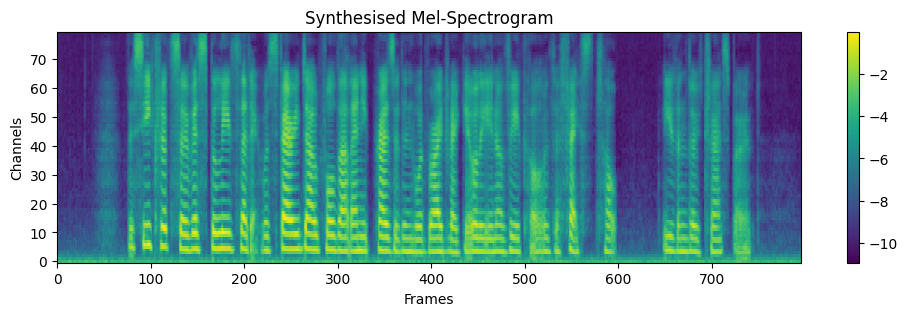

1 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 47


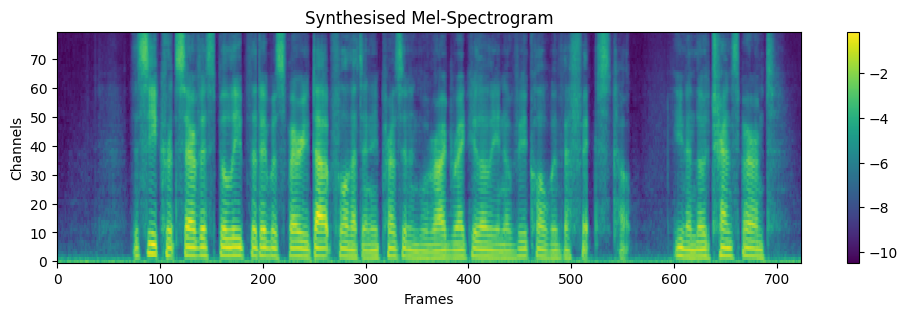

2 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 91


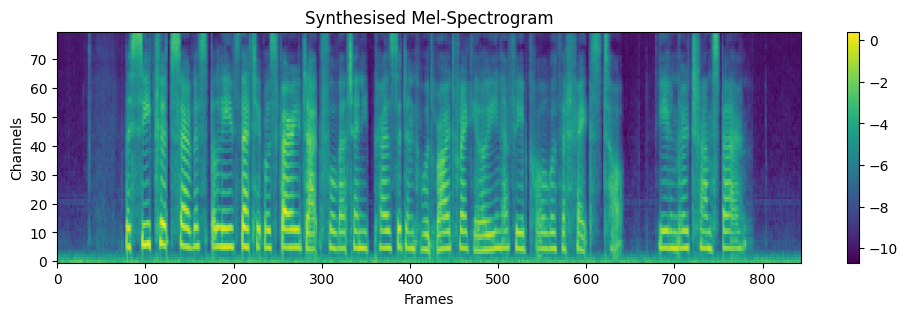

3 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 13


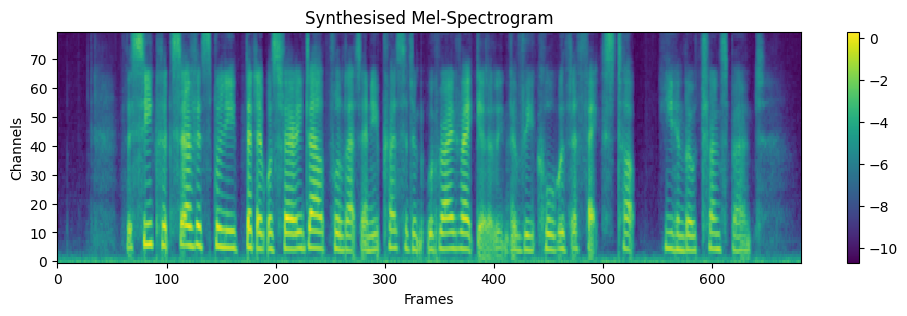

4 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 33


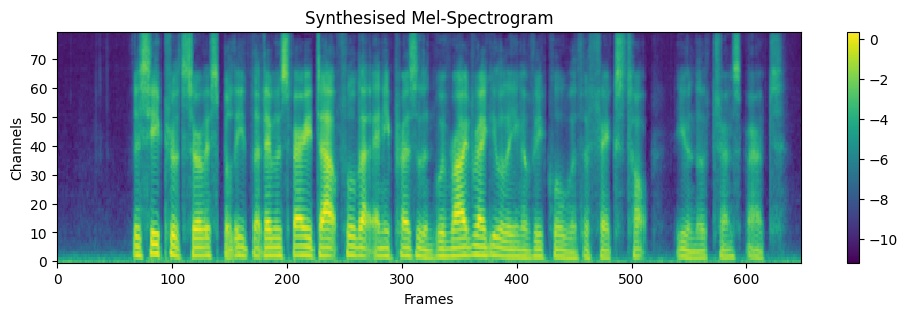

5 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 12


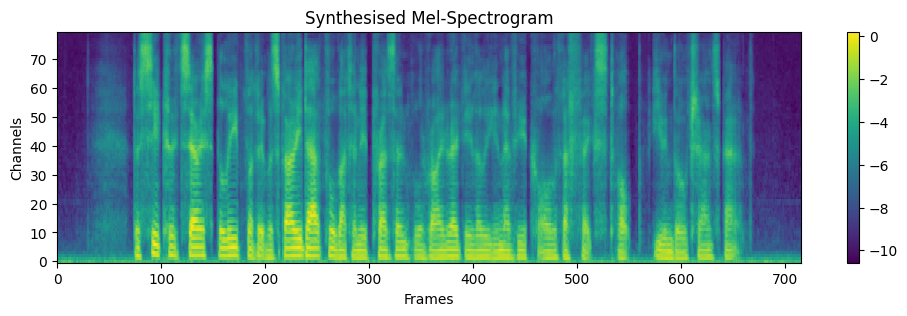

6 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 85


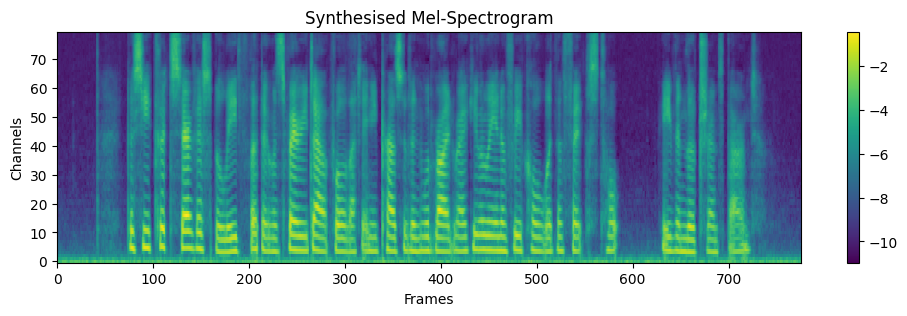

7 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 4


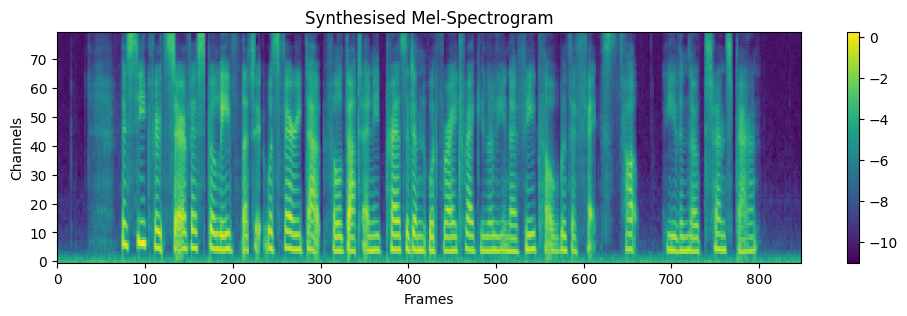

8 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 5


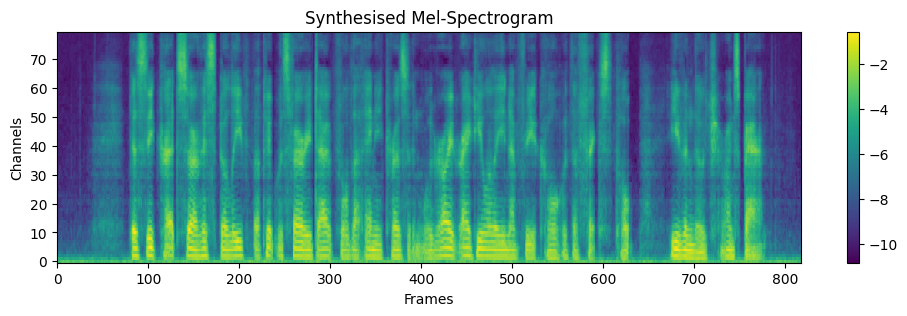

9 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 60


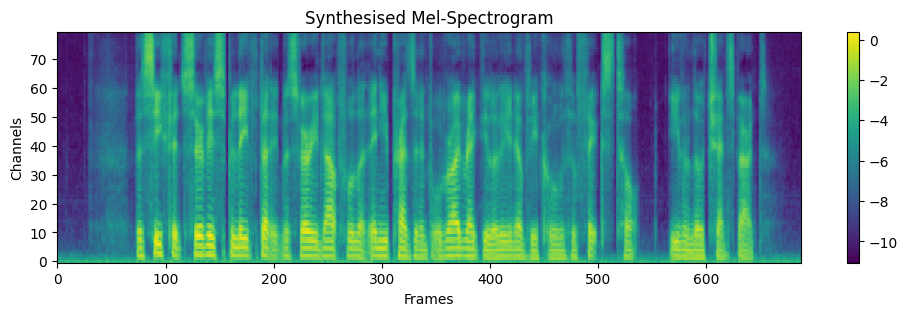

10 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 51


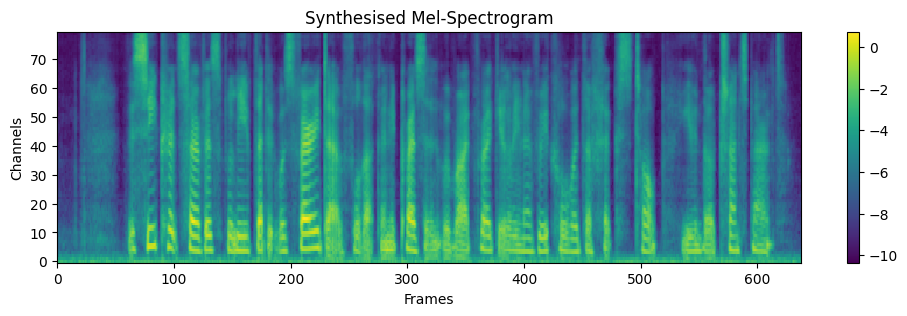

11 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 26


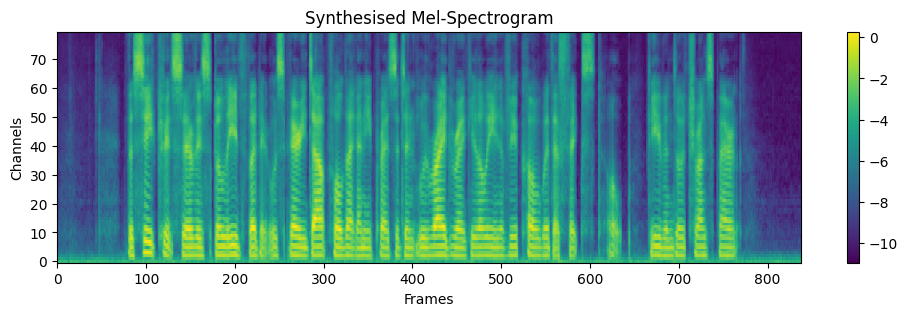

12 The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent. 15


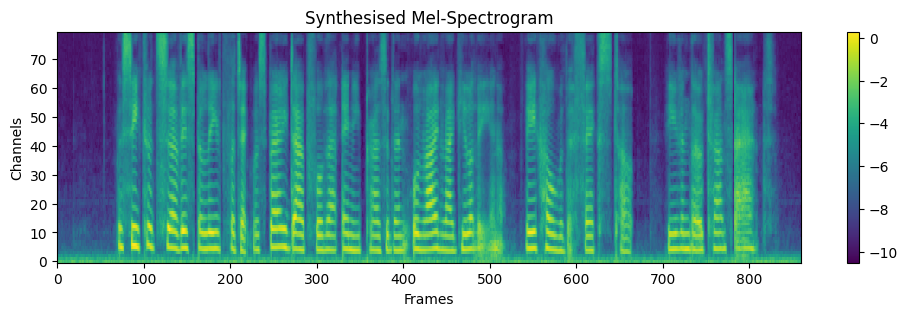

In [95]:
for i, mel_output in enumerate(mel_outputs):
    print(i, texts[i], speaker_ids[i])
    plot_spectrogram_to_numpy(np.array(mel_output.float().cpu()).T)

### Synthesize audio from spectrogram using HiFiGAN

### Interesting denoising

In [96]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = mel_output.transpose(1, 2)
        audio = generator(mel_output)
        audio = denoiser(audio[:, 0], strength=0.001)[:, 0]
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        print(f"Speaker: {speaker_ids[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 71


***********************************

********** 	2	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 47


***********************************

********** 	3	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 91


***********************************

********** 	4	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 13


***********************************

********** 	5	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 33


***********************************

********** 	6	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 12


***********************************

********** 	7	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 85


***********************************

********** 	8	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 4


***********************************

********** 	9	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 5


***********************************

********** 	10	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 60


***********************************

********** 	11	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 51


***********************************

********** 	12	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 26


***********************************

********** 	13	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Speaker: 15


***********************************



### Save to wav files using soundfile

In [97]:
import soundfile as sf
from pathlib import Path

basepath = Path('multispeaker_synth')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
        filename = basepath / f'Speaker_{speaker_ids[i]}.wav'
        sr = 22500
        sf.write(filename, audio.data.squeeze().cpu().numpy(), 
                 22500, 'PCM_24')
        print(f'Successfully written: {filename}')


Successfully written: multispeaker_synth/Speaker_71.wav
Successfully written: multispeaker_synth/Speaker_47.wav
Successfully written: multispeaker_synth/Speaker_91.wav
Successfully written: multispeaker_synth/Speaker_13.wav
Successfully written: multispeaker_synth/Speaker_33.wav
Successfully written: multispeaker_synth/Speaker_12.wav
Successfully written: multispeaker_synth/Speaker_85.wav
Successfully written: multispeaker_synth/Speaker_4.wav
Successfully written: multispeaker_synth/Speaker_5.wav
Successfully written: multispeaker_synth/Speaker_60.wav
Successfully written: multispeaker_synth/Speaker_51.wav
Successfully written: multispeaker_synth/Speaker_26.wav
Successfully written: multispeaker_synth/Speaker_15.wav
